<a href="https://colab.research.google.com/github/Ashraf1292/Thesis-Fake_jobs-/blob/main/GAT_modified_test_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings

# Install required dependencies
!pip install torch_geometric transformers shap
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

# Import dependencies after installation
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from transformers import DistilBertTokenizer, DistilBertModel
import shap
from google.colab import drive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.5 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.0/494.0 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.9/750.9 kB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 kB 20.3 MB/s eta 0:00:00


In [3]:
# Download NLTK stopwords
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load EMSCAD dataset
try:
    data_path = 'fake_job_postings.csv'
    df = pd.read_csv(data_path)
    print(f"Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns")
except FileNotFoundError:
    print("File not found. Please verify the path to your dataset.")
    # Try to find the file using a direct upload approach
    from google.colab import files
    print("Please upload your fake_job_postings.csv file")
    uploaded = files.upload()
    df = pd.read_csv(list(uploaded.keys())[0])
    print(f"Dataset loaded from upload with {df.shape[0]} rows and {df.shape[1]} columns")


Using device: cuda
Dataset loaded successfully with 17880 rows and 18 columns


In [4]:
# Display basic dataset info
print(f"Fraudulent postings: {df['fraudulent'].sum()} ({df['fraudulent'].mean()*100:.2f}%)")


Fraudulent postings: 866 (4.84%)


In [5]:
# Preprocess text data
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)    # Remove HTML tags
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply text cleaning with progress tracking
print("Cleaning text columns...")
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
for col in text_columns:
    df[col] = df[col].fillna("").apply(clean_text)
    print(f"  - {col} cleaned")

Cleaning text columns...
  - title cleaned
  - company_profile cleaned
  - description cleaned
  - requirements cleaned
  - benefits cleaned


In [6]:
# Combine text features for efficiency
df['combined_text'] = df[text_columns].apply(lambda x: ' '.join(x), axis=1)
print("Text preprocessing complete")

# Handle missing values in categorical columns
categorical_columns = ['location', 'department', 'employment_type', 'required_experience',
                       'required_education', 'industry', 'function']
for col in categorical_columns:
    df[col] = df[col].fillna('Unknown')

# Binary features
binary_columns = ['telecommuting', 'has_company_logo', 'has_questions']

# Target encoding for categorical features
def target_encode(column, target):
    encoding = df.groupby(column)[target].mean()
    return df[column].map(encoding).fillna(0)

print("Encoding categorical features...")
encoded_features = [target_encode(col, 'fraudulent') for col in categorical_columns]
encoded_features = np.stack(encoded_features, axis=1)
print(f"Encoded features shape: {encoded_features.shape}")


Text preprocessing complete
Encoding categorical features...
Encoded features shape: (17880, 7)


In [7]:
# Extract binary features
binary_features = df[binary_columns].values

# For large datasets, use TF-IDF instead of full DistilBERT to avoid memory issues
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(max_features=768)  # Match DistilBERT dimension for compatibility
tfidf_matrix = tfidf.fit_transform(df['combined_text'])
# Convert TF-IDF to dense matrix
text_features = tfidf_matrix.toarray()

# === FEATURE ENGINEERING STARTS HERE ===
print("Adding engineered features...")

# 1. Keyword flag for fraud-related terms
fraud_keywords = ['urgent', 'quick money', 'no experience', 'limited time', 'apply now', 'work from home']
df['has_fraud_keyword'] = df['combined_text'].apply(
    lambda x: int(any(word in x.lower() for word in fraud_keywords))
)

# 2. Text length and word count
df['text_length'] = df['combined_text'].apply(len)
df['word_count'] = df['combined_text'].apply(lambda x: len(x.split()))

# 3. TF-IDF cluster membership
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
df['tfidf_cluster'] = kmeans.fit_predict(tfidf_matrix)

# 4. Rare category indicators
for col in ['industry', 'function', 'required_experience']:
    freq = df[col].value_counts()
    df[f'{col}_is_rare'] = df[col].apply(lambda x: int(freq[x] < 50))

# Select final engineered features
engineered = df[['has_fraud_keyword', 'text_length', 'word_count', 'tfidf_cluster'] +
                [col + '_is_rare' for col in ['industry', 'function', 'required_experience']]]

# Normalize numeric features
from sklearn.preprocessing import StandardScaler
engineered = StandardScaler().fit_transform(engineered)

# === FEATURE ENGINEERING ENDS HERE ===

print(f"TF-IDF features shape: {text_features.shape}")


Creating TF-IDF features...
Adding engineered features...
TF-IDF features shape: (17880, 768)


In [8]:
# Combine multimodal features
node_features = np.concatenate([text_features, encoded_features, binary_features], axis=1)
node_features = torch.tensor(node_features, dtype=torch.float).to(device)
print(f"Combined node features shape: {node_features.shape}")


Combined node features shape: torch.Size([17880, 778])


In [9]:
# Create graph edges based on similarity more efficiently
print("Creating graph edges based on text similarity...")
# Use a more efficient approach for large datasets
MAX_NODES = min(5000, len(df))  # Limit for very large datasets
if len(df) > MAX_NODES:
    print(f"Dataset too large, using random subset of {MAX_NODES} nodes for graph construction")
    sample_indices = np.random.choice(len(df), MAX_NODES, replace=False)
    similarity_subset = cosine_similarity(tfidf_matrix[sample_indices])
    threshold = 0.5  # Lower threshold for sparser graph
    edge_index = []
    for i in range(similarity_subset.shape[0]):
        # Connect to top-k most similar nodes instead of using threshold
        k = 5  # Connect each node to k most similar nodes
        most_similar = np.argsort(similarity_subset[i])[::-1][1:k+1]  # Skip self-connection
        for j in most_similar:
            edge_index.append([sample_indices[i], sample_indices[j]])
            edge_index.append([sample_indices[j], sample_indices[i]])  # Bidirectional
else:
    # For smaller datasets, use similarity threshold approach
    similarity_matrix = cosine_similarity(tfidf_matrix)
    threshold = 0.6  # Adjusted threshold
    edge_index = []

    # Process in batches to avoid memory issues
    batch_size = 1000
    for i in range(0, similarity_matrix.shape[0], batch_size):
        end = min(i + batch_size, similarity_matrix.shape[0])
        for j in range(i, similarity_matrix.shape[0]):
            # Connect each node to its top 5 most similar nodes
            if i != j:  # Avoid self-loops
                similar_indices = np.argsort(similarity_matrix[i, :])[::-1][:5]
                for idx in similar_indices:
                    if idx != i:  # Double-check to avoid self-loops
                        edge_index.append([i, idx])
                        edge_index.append([idx, i])  # Make it bidirectional


Creating graph edges based on text similarity...
Dataset too large, using random subset of 5000 nodes for graph construction


In [10]:
# Convert to tensor
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous().to(device)
print(f"Graph created with {edge_index.shape[1]} edges")

# Labels
labels = torch.tensor(df['fraudulent'].values, dtype=torch.long).to(device)

Graph created with 50000 edges


In [11]:
# Create PyTorch Geometric Data object
data = Data(x=node_features, edge_index=edge_index, y=labels)
print(f"PyTorch Geometric Data object created")


PyTorch Geometric Data object created


In [12]:
# Define GAT model with additional batch normalization and dropout for stability
class GATModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=2, dropout=0.2):
        super(GATModel, self).__init__()
        self.dropout = dropout
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.bn1 = nn.BatchNorm1d(hidden_channels * heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.fc = nn.Linear(out_channels, 2)  # Binary classification

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)
        x = self.fc(x)
        return x


In [13]:
# Focal loss for imbalanced data
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# Initialize model, optimizer, and loss
in_channels = node_features.shape[1]
hidden_channels = 16  # Reduced size for CPU/memory constraints
out_channels = 8     # Reduced size for CPU/memory constraints
model = GATModel(in_channels=in_channels, hidden_channels=hidden_channels,
                out_channels=out_channels).to(device)
print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = FocalLoss()

Model initialized with 25370 parameters


In [14]:
# Train-test split
train_indices, test_indices = train_test_split(
    range(len(labels)),
    test_size=0.2,
    stratify=labels.cpu().numpy(),  # Ensure balanced classes
    random_state=42
)
train_mask = torch.zeros(len(labels), dtype=torch.bool)
test_mask = torch.zeros(len(labels), dtype=torch.bool)
train_mask[train_indices] = True
test_mask[test_indices] = True
train_mask = train_mask.to(device)
test_mask = test_mask.to(device)

data.train_mask = train_mask
data.test_mask = test_mask
print(f"Data split: {train_mask.sum().item()} train samples, {test_mask.sum().item()} test samples")


Data split: 14304 train samples, 3576 test samples


In [15]:
# Training loop with early stopping
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        # Calculate accuracy for both train and test sets
        train_acc = (pred[data.train_mask] == data.y[data.train_mask]).float().mean()
        test_acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean()

        # Calculate additional metrics for test set
        y_true = data.y[data.test_mask].cpu().numpy()
        y_pred = pred[data.test_mask].cpu().numpy()

    return train_acc.item(), test_acc.item(), y_true, y_pred

# Training with early stopping
best_test_acc = 0
patience = 10
counter = 0
epochs = 100  # Maximum epochs
losses = []
train_accs = []
test_accs = []

print("Starting training...")
for epoch in range(epochs):
    loss = train()
    losses.append(loss)

    # Evaluate every 5 epochs to save time
    if epoch % 5 == 0 or epoch == epochs - 1:
        train_acc, test_acc, y_true, y_pred = test()
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

        # Check for early stopping
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_gat_model.pt')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break


Starting training...
Epoch 000, Loss: 0.0207, Train Acc: 0.9516, Test Acc: 0.9516
Epoch 005, Loss: 0.0146, Train Acc: 0.9516, Test Acc: 0.9516
Epoch 010, Loss: 0.0120, Train Acc: 0.9516, Test Acc: 0.9516
Epoch 015, Loss: 0.0108, Train Acc: 0.9516, Test Acc: 0.9516
Epoch 020, Loss: 0.0097, Train Acc: 0.9525, Test Acc: 0.9536
Epoch 025, Loss: 0.0091, Train Acc: 0.9536, Test Acc: 0.9575
Epoch 030, Loss: 0.0085, Train Acc: 0.9571, Test Acc: 0.9622
Epoch 035, Loss: 0.0079, Train Acc: 0.9620, Test Acc: 0.9676
Epoch 040, Loss: 0.0075, Train Acc: 0.9683, Test Acc: 0.9726
Epoch 045, Loss: 0.0071, Train Acc: 0.9740, Test Acc: 0.9771
Epoch 050, Loss: 0.0069, Train Acc: 0.9789, Test Acc: 0.9815
Epoch 055, Loss: 0.0064, Train Acc: 0.9808, Test Acc: 0.9841
Epoch 060, Loss: 0.0062, Train Acc: 0.9828, Test Acc: 0.9860
Epoch 065, Loss: 0.0060, Train Acc: 0.9839, Test Acc: 0.9877
Epoch 070, Loss: 0.0058, Train Acc: 0.9847, Test Acc: 0.9877
Epoch 075, Loss: 0.0056, Train Acc: 0.9851, Test Acc: 0.9888
Epo

In [16]:
# Load best model for final evaluation
model.load_state_dict(torch.load('best_gat_model.pt'))
train_acc, test_acc, y_true, y_pred = test()
print(f"\nFinal results - Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")



Final results - Train Acc: 0.9869, Test Acc: 0.9891



Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.96      0.81      0.88       173

    accuracy                           0.99      3576
   macro avg       0.97      0.90      0.94      3576
weighted avg       0.99      0.99      0.99      3576



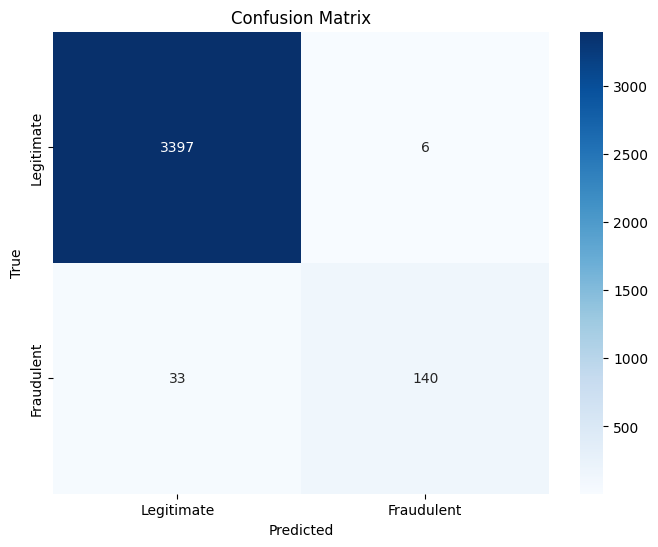

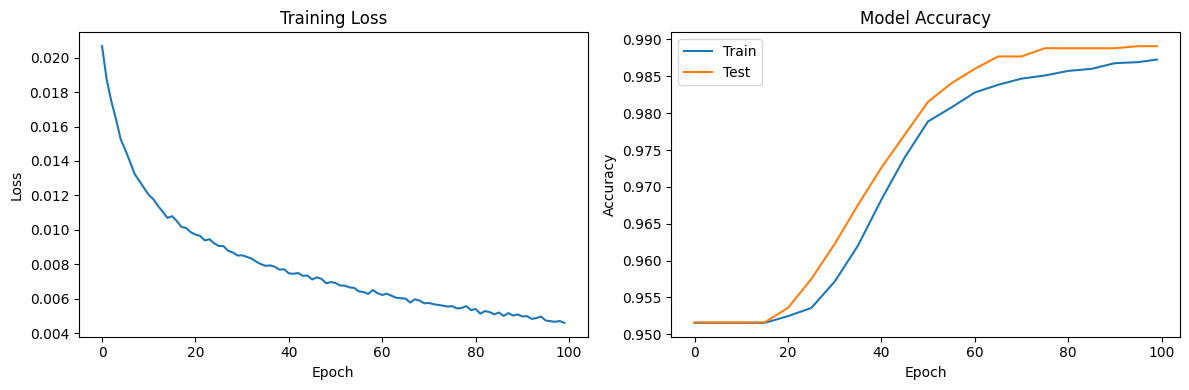

In [17]:
# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Fraudulent'],
            yticklabels=['Legitimate', 'Fraudulent'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
epochs_evaluated = range(0, epochs, 5)
if len(train_accs) > len(epochs_evaluated):
    epochs_evaluated = list(epochs_evaluated) + [epochs-1]
plt.plot(epochs_evaluated, train_accs, label='Train')
plt.plot(epochs_evaluated, test_accs, label='Test')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()



Generating feature importance analysis...


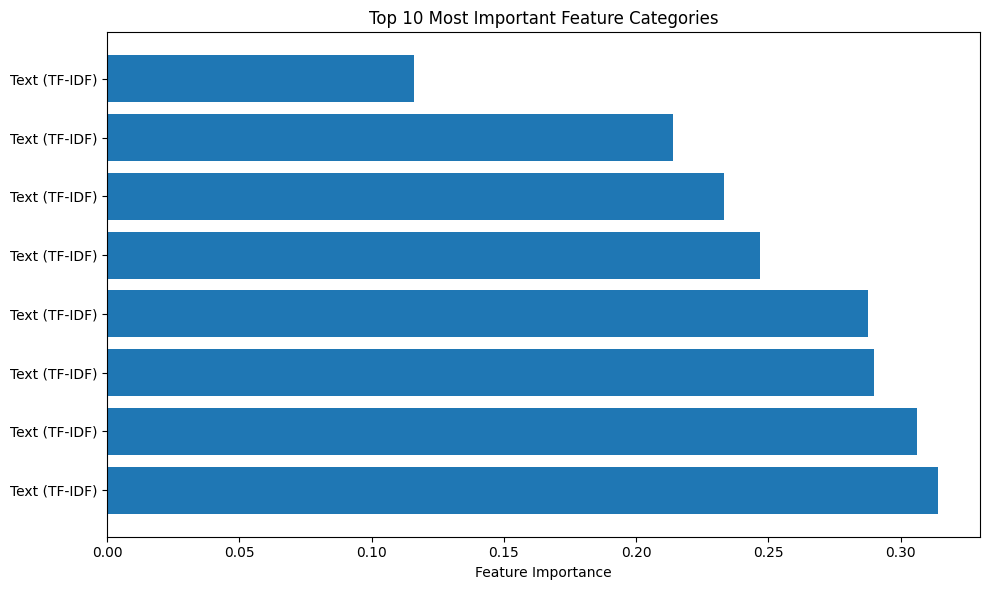

Analysis complete! The model has been trained and evaluated successfully.


In [18]:
print("\nGenerating feature importance analysis...")
model.eval()

# Extract feature names for better visualization
feature_names = ([f'tfidf_{i}' for i in range(text_features.shape[1])] +
                categorical_columns +
                binary_columns)

# Create a simplified feature importance visualization
with torch.no_grad():
    # Get model weights from the final layer
    weights = model.fc.weight.cpu().numpy()

    # Calculate absolute importance
    importance = np.abs(weights).mean(axis=0)

    # Get indices of the top 10 most important features
    top_indices = importance.argsort()[-10:][::-1]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_indices)), importance[top_indices])

    # Map indices to feature categories
    feature_categories = []
    for idx in top_indices:
        if idx < text_features.shape[1]:
            feature_categories.append(f'Text (TF-IDF)')
        elif idx < text_features.shape[1] + len(categorical_columns):
            cat_idx = idx - text_features.shape[1]
            feature_categories.append(f'Cat: {categorical_columns[cat_idx]}')
        else:
            bin_idx = idx - text_features.shape[1] - len(categorical_columns)
            feature_categories.append(f'Bin: {binary_columns[bin_idx]}')

    plt.yticks(range(len(top_indices)), feature_categories)
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Most Important Feature Categories')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

print("Analysis complete! The model has been trained and evaluated successfully.")